## 1. Initialize Spark Session & Import Libraries

In [2]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, split, when, count, explode
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# MLlib imports
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
import os 
import subprocess 
# Set environment variables BEFORE importing SparkContext
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk'
os.environ['HADOOP_USER_NAME'] = subprocess.check_output('whoami').decode().strip()

# Disable Hadoop features that require HDFS
os.environ['HADOOP_DATANODE_USER'] = os.environ['HADOOP_USER_NAME']
os.environ['HADOOP_NAMENODE_USER'] = os.environ['HADOOP_USER_NAME']
os.environ['HADOOP_SECONDARYNAMENODE_USER'] = os.environ['HADOOP_USER_NAME']

# Set Java options before Spark context
os.environ['_JAVA_OPTIONS'] = '-Duser.country=US -Duser.language=en'

print("Environment Variables Set:")
print(f"JAVA_HOME: {os.environ.get('JAVA_HOME')}")
print(f"HADOOP_USER_NAME: {os.environ.get('HADOOP_USER_NAME')}")
# well configured spark 
spark = SparkSession.builder \
    .appName("TwitterSentimentAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.driver.extraJavaOptions", 
            "-Duser.country=US -Duser.language=en -Djavax.security.auth.useSubjectCredsOnly=false") \
    .config("spark.executor.extraJavaOptions", 
            "-Duser.country=US -Duser.language=en -Djavax.security.auth.useSubjectCredsOnly=false") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .config("spark.broadcast.blockSize", "128m") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.task.maxSize", "512m") \
    .config("spark.broadcast.blockSize", "256m") \
    .config("spark.kryoserializer.buffer.max", "1g") \
    .getOrCreate()

# Set log level to reduce output
spark.sparkContext.setLogLevel("WARN")

print("\n" + "="*60)
print("Spark Session Initialized Successfully!")
print("="*60)
print(f"Spark Version: {spark.version}")
print(f"Application Name: {spark.sparkContext.appName}")
print(f"Master: {spark.sparkContext.master}")
print("="*60)

Environment Variables Set:
JAVA_HOME: /usr/lib/jvm/java-11-openjdk
HADOOP_USER_NAME: meduk0


Picked up _JAVA_OPTIONS: -Duser.country=US -Duser.language=en
Picked up _JAVA_OPTIONS: -Duser.country=US -Duser.language=en
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/11 11:31:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.



Spark Session Initialized Successfully!
Spark Version: 3.5.0
Application Name: TwitterSentimentAnalysis
Master: local[*]


## 2. Load and Explore Data

In [4]:
# Read training data into Spark DataFrame
import os

# Get the current working directory and construct file paths
data_dir = os.getcwd()
train_file = os.path.join(data_dir, '../data/twitter_training.csv')
val_file = os.path.join(data_dir, '../data/twitter_validation.csv')

print(f"Loading data from: {data_dir}")
print(f"Training file: {train_file}")
print(f"Validation file: {val_file}")

# Read using file:// protocol for local filesystem
spark_train_df = spark.read.csv(f'file://{train_file}', header=False, inferSchema=True)
spark_train_df = spark_train_df.toDF('id', 'game', 'sentiment', 'text')

# Read validation data
spark_val_df = spark.read.csv(f'file://{val_file}', header=False, inferSchema=True)
spark_val_df = spark_val_df.toDF('id', 'game', 'sentiment', 'text')

print(f"\nTraining Dataset: {spark_train_df.count()} records")
print(f"Validation Dataset: {spark_val_df.count()} records")

Loading data from: /home/meduk0/Documents/framework/project/notebooks
Training file: /home/meduk0/Documents/framework/project/notebooks/../data/twitter_training.csv
Validation file: /home/meduk0/Documents/framework/project/notebooks/../data/twitter_validation.csv



Training Dataset: 74682 records
Validation Dataset: 1510 records


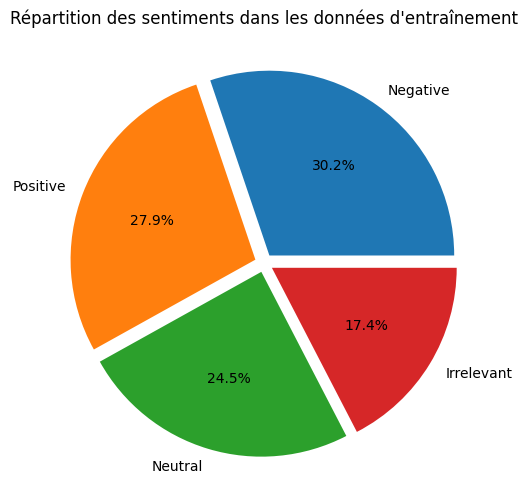

    sentiment  count
3    Negative  22542
1    Positive  20832
2     Neutral  18318
0  Irrelevant  12990


In [11]:
# Sentiment distribution visualization
sentiment_dist = spark_train_df.groupBy('sentiment').count().toPandas()
sentiment_dist = sentiment_dist.sort_values('count', ascending=False)

plt.figure(figsize=(10, 6))
plt.pie(sentiment_dist['count'], labels=sentiment_dist['sentiment'], autopct='%1.1f%%', 
        explode=[0.05]*len(sentiment_dist))
plt.title('Répartition des sentiments dans les données d\'entraînement')
plt.show()

print(sentiment_dist)

In [40]:
# Display schema
print("\nTraining Data Schema:")
spark_train_df.printSchema()

# Show sample data
print("\nSample Training Data:")
spark_train_df.select('sentiment', 'game', 'text').limit(5).show(truncate=False)


Training Data Schema:
root
 |-- id: integer (nullable = true)
 |-- game: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- text: string (nullable = true)


Sample Training Data:
+---------+-----------+---------------------------------------------------------+
|sentiment|game       |text                                                     |
+---------+-----------+---------------------------------------------------------+
|Positive |Borderlands|im getting on borderlands and i will murder you all ,    |
|Positive |Borderlands|I am coming to the borders and I will kill you all,      |
|Positive |Borderlands|im getting on borderlands and i will kill you all,       |
|Positive |Borderlands|im coming on borderlands and i will murder you all,      |
|Positive |Borderlands|im getting on borderlands 2 and i will murder you me all,|
+---------+-----------+---------------------------------------------------------+



In [41]:
# Basic statistics
print("\nSentiment Distribution (Training):")
spark_train_df.groupBy('sentiment').count().show()

print("\nGame Distribution (Training):")
spark_train_df.groupBy('game').count().show()


Sentiment Distribution (Training):
+----------+-----+
| sentiment|count|
+----------+-----+
|Irrelevant|12990|
|  Positive|20832|
|   Neutral|18318|
|  Negative|22542|
+----------+-----+


Game Distribution (Training):
+--------------------+-----+
|                game|count|
+--------------------+-----+
|         Borderlands| 2286|
|       Xbox(Xseries)| 2334|
|   PlayStation5(PS5)| 2310|
|           Overwatch| 2334|
|        WorldOfCraft| 2364|
|      AssassinsCreed| 2244|
|               CS-GO| 2304|
|               NBA2K| 2352|
|              Google| 2298|
|               Dota2| 2364|
|CallOfDutyBlackop...| 2376|
|     LeagueOfLegends| 2394|
|              Amazon| 2316|
|         ApexLegends| 2376|
|                FIFA| 2340|
|             Verizon| 2382|
|PlayerUnknownsBat...| 2274|
|         Battlefield| 2346|
| GrandTheftAuto(GTA)| 2304|
|           HomeDepot| 2310|
+--------------------+-----+
only showing top 20 rows



In [42]:
# Check for null values
print("\nNull Value Analysis:")
spark_train_df.select([when(col(c).isNull(), 1).otherwise(0).alias(c) for c in spark_train_df.columns]).agg(
    {col: 'sum' for col in spark_train_df.columns}
).show()


Null Value Analysis:
+--------------+---------+-------+---------+
|sum(sentiment)|sum(game)|sum(id)|sum(text)|
+--------------+---------+-------+---------+
|             0|        0|      0|      686|
+--------------+---------+-------+---------+



## 3. Data Preparation 

<Axes: >

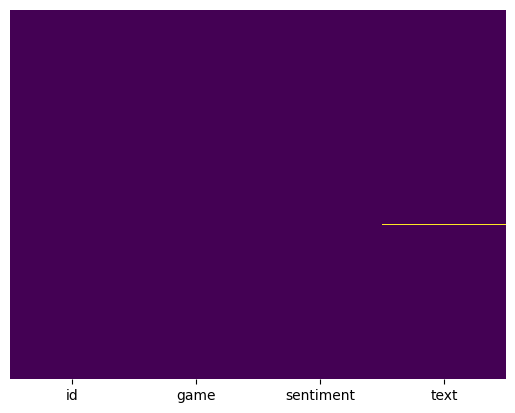

In [43]:
sns.heatmap(spark_train_df.toPandas().isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [44]:
# Remove null values from text column
spark_train_df = spark_train_df.filter(col('text').isNotNull())
spark_val_df = spark_val_df.filter(col('text').isNotNull())

print(f"Training data after null removal: {spark_train_df.count()} records")
print(f"Validation data after null removal: {spark_val_df.count()} records")

Training data after null removal: 73996 records
Validation data after null removal: 1000 records


In [45]:
# Apply data reduction for balanced classes (equal ratio like original notebook)
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, rand

# Count by sentiment
sentiment_counts = spark_train_df.groupBy('sentiment').count().collect()
print("\nSentiment Counts Before Reduction:")
for row in sentiment_counts:
    print(f"{row['sentiment']}: {row['count']}")




Sentiment Counts Before Reduction:
Irrelevant: 12875
Positive: 20655
Neutral: 18108
Negative: 22358


In [46]:
# Verify distribution
print("\nSentiment Distribution before Balancing:")
spark_train_df.groupBy('sentiment').count().show()


Sentiment Distribution before Balancing:
+----------+-----+
| sentiment|count|
+----------+-----+
|Irrelevant|12875|
|  Positive|20655|
|   Neutral|18108|
|  Negative|22358|
+----------+-----+



## 4. Exploratory Data Analysis on Spark DataFrames (before balancing)

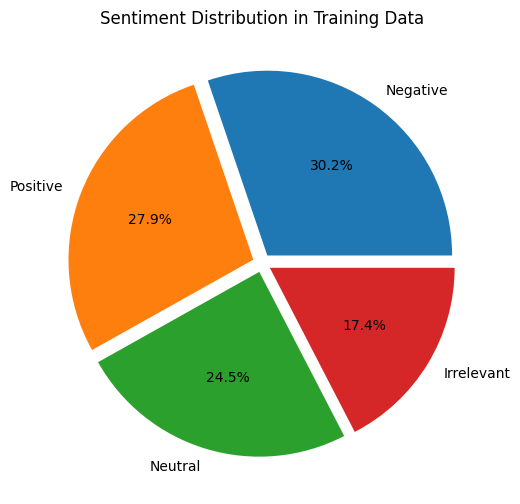

    sentiment  count
3    Negative  22358
1    Positive  20655
2     Neutral  18108
0  Irrelevant  12875


In [47]:
# Sentiment distribution visualization
sentiment_dist = spark_train_df.groupBy('sentiment').count().toPandas()
sentiment_dist = sentiment_dist.sort_values('count', ascending=False)

plt.figure(figsize=(10, 6))
plt.pie(sentiment_dist['count'], labels=sentiment_dist['sentiment'], autopct='%1.1f%%', 
        explode=[0.05]*len(sentiment_dist))
plt.title('Sentiment Distribution in Training Data')
plt.show()

print(sentiment_dist)

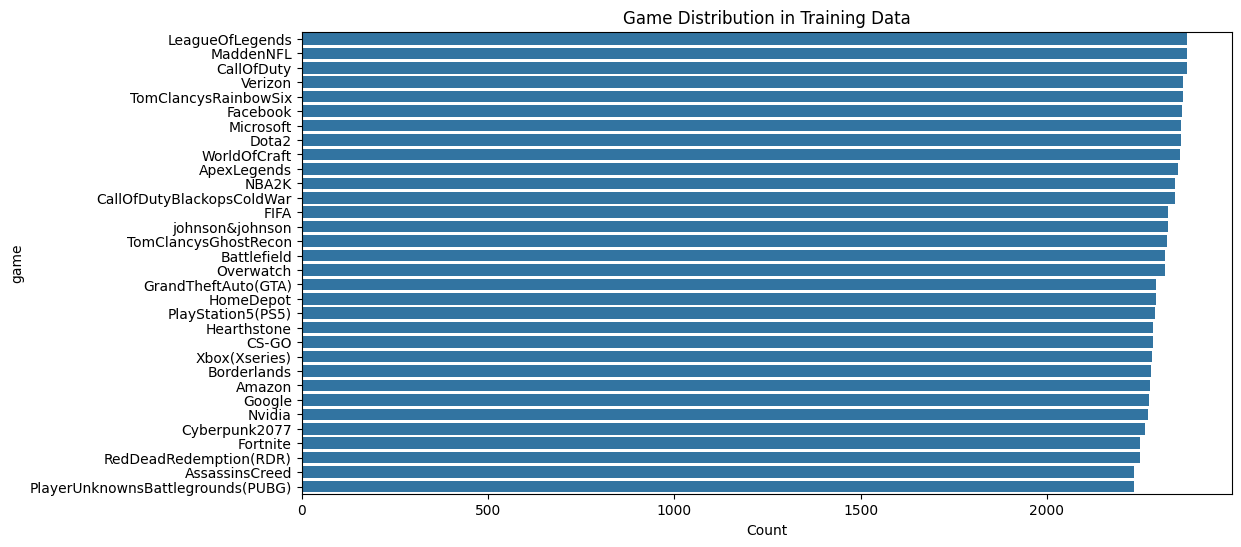

                                 game  count
11                    LeagueOfLegends   2377
28                          MaddenNFL   2377
25                         CallOfDuty   2376
15                            Verizon   2365
23               TomClancysRainbowSix   2364
26                           Facebook   2362
21                          Microsoft   2361
9                               Dota2   2359
4                        WorldOfCraft   2357
13                        ApexLegends   2353
7                               NBA2K   2343
10          CallOfDutyBlackopsColdWar   2343
14                               FIFA   2324
31                    johnson&johnson   2324
30               TomClancysGhostRecon   2321
17                        Battlefield   2316
3                           Overwatch   2316
18                GrandTheftAuto(GTA)   2293
19                          HomeDepot   2292
2                   PlayStation5(PS5)   2291
24                        Hearthstone   2286
6         

In [48]:
# Game distribution
game_dist = spark_train_df.groupBy('game').count().toPandas()
game_dist = game_dist.sort_values('count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='game', data=game_dist)
plt.title('Game Distribution in Training Data')
plt.xlabel('Count')
plt.show()

print(game_dist)

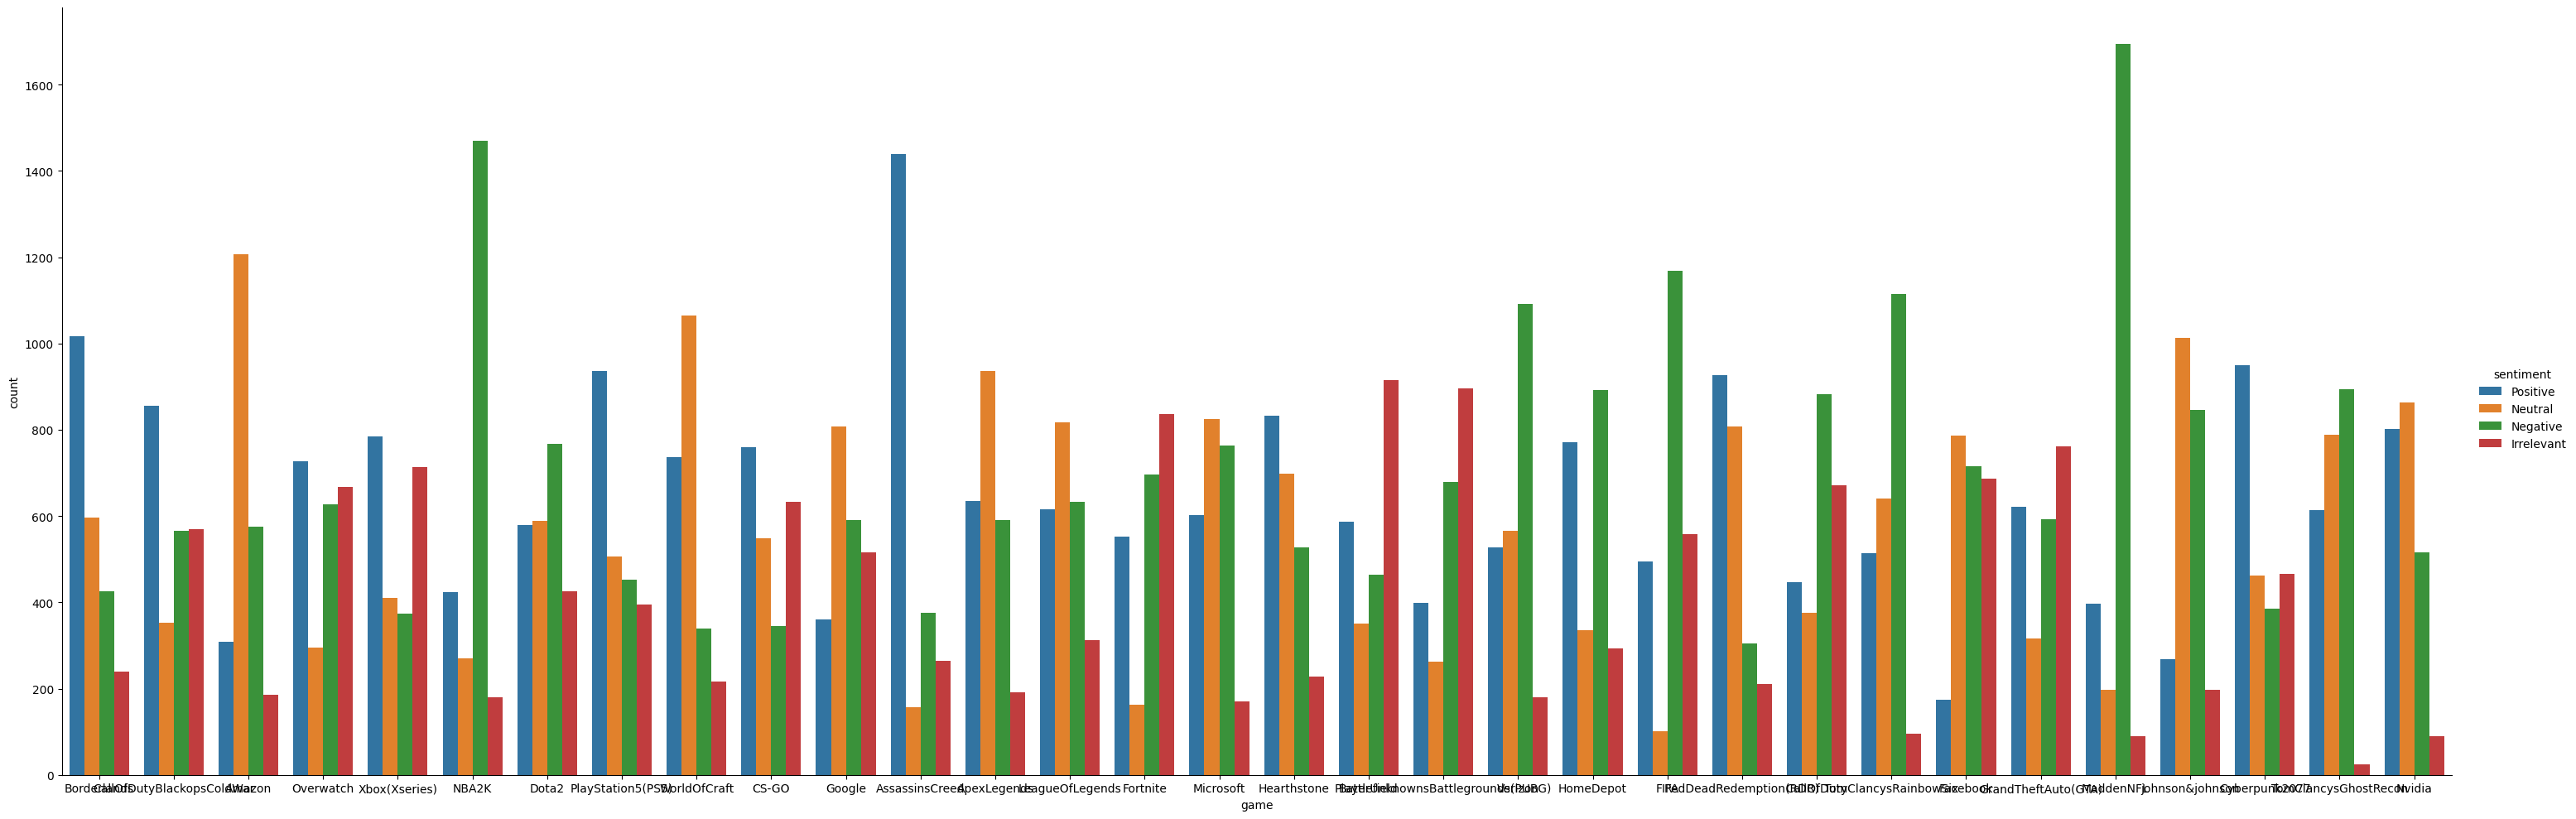

In [49]:
# Sentiment vs Game distribution
sns.catplot(x="game", hue="sentiment", kind="count", height=10, aspect=3, data=spark_train_df.toPandas())

Data balancing 

In [50]:
# Calculate minimum reduction ratio (divide by 12 like original)
min_samples = min([row['count'] for row in sentiment_counts])
print(f"\nTarget samples per sentiment: {min_samples}") # min_samples is now 12875
# Balance the dataset
balanced_dfs = []
for sentiment_val in spark_train_df.select('sentiment').distinct().collect():
    sentiment = sentiment_val['sentiment']
    df_sentiment = spark_train_df.filter(col('sentiment') == sentiment) \
        .orderBy(rand()) \
        .limit(min_samples)
    balanced_dfs.append(df_sentiment)

spark_train_df = balanced_dfs[0]
for df in balanced_dfs[1:]:
    spark_train_df = spark_train_df.union(df)

print(f"\nTraining data after balancing: {spark_train_df.count()} records")


Target samples per sentiment: 12875

Training data after balancing: 51500 records


In [51]:
# Verify distribution
print("\nSentiment Distribution after Balancing:")
spark_train_df.groupBy('sentiment').count().show()


Sentiment Distribution after Balancing:
+----------+-----+
| sentiment|count|
+----------+-----+
|Irrelevant|12875|
|  Positive|12875|
|   Neutral|12875|
|  Negative|12875|
+----------+-----+



## 5. Text Preprocessing with MLlib Pipeline

In [52]:
# Enhanced text cleaning function using Spark SQL functions
from pyspark.sql.functions import udf
import re

# Create UDF for improved text preprocessing
def clean_text(text):
    if text is None:
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove mentions and hashtags (keep words)
    text = re.sub(r'[@#]', '', text)
    # Remove emojis and special unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Handle common contractions
    contractions = {
        "n't": " not", "'re": " are", "'s": " is", "'d": " would",
        "'ll": " will", "'ve": " have", "'m": " am"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

clean_text_udf = udf(clean_text, StringType())

# Apply cleaning
spark_train_df = spark_train_df.withColumn('cleaned_text', clean_text_udf(col('text')))
spark_val_df = spark_val_df.withColumn('cleaned_text', clean_text_udf(col('text')))

# Cache for better performance
spark_train_df.cache()
spark_val_df.cache()

print("\nSample cleaned text:")
spark_train_df.select('text', 'cleaned_text').limit(3).show(truncate=False)


Sample cleaned text:


25/12/11 09:26:39 WARN CacheManager: Asked to cache already cached data.


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                  |cleaned_text                                                                                                                                                                                                    |
+---------------------------------------------------------------------------------------------------------------------------------------------------

In [53]:
# Repartition to reduce broadcasting overhead
print("\nOptimizing data partitions...")
spark_train_df = spark_train_df.repartition(32)
spark_val_df = spark_val_df.repartition(16)
print("Data repartitioned for better broadcast efficiency")


Optimizing data partitions...
Data repartitioned for better broadcast efficiency


In [54]:
# Index the sentiment labels
# IMPORTANT: Fit the StringIndexer on training data, then transform both datasets
label_indexer = StringIndexer(inputCol="sentiment", outputCol="label")

# Fit the indexer on training data
label_model = label_indexer.fit(spark_train_df)

# Transform both training and validation datasets using the fitted model
indexed_train_df = label_model.transform(spark_train_df)
indexed_val_df = label_model.transform(spark_val_df)

# Cache indexed dataframes for performance
indexed_train_df.cache()
indexed_val_df.cache()

print("\nLabel Mapping:")
indexed_train_df.select('sentiment', 'label').distinct().orderBy('label').show()

print("\nSample indexed data:")
indexed_train_df.select('sentiment', 'label', 'cleaned_text').limit(3).show(truncate=False)


Label Mapping:
+----------+-----+
| sentiment|label|
+----------+-----+
|Irrelevant|  0.0|
|  Negative|  1.0|
|   Neutral|  2.0|
|  Positive|  3.0|
+----------+-----+


Sample indexed data:
+----------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment |label|cleaned_text                                                                                                                                                                                                             |
+----------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Irrelevant|0.0  |i fucking hate any driver mfs think driving is real life gta literally more an a

## 6. Feature Engineering with MLlib Transformers

In [55]:
# Create tokenizer
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")

# Create stop words remover
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Apply tokenization and stop word removal
tokenized_train_df = tokenizer.transform(indexed_train_df)
filtered_train_df = remover.transform(tokenized_train_df)

tokenized_val_df = tokenizer.transform(indexed_val_df)
filtered_val_df = remover.transform(tokenized_val_df)

print("\nSample filtered tokens:")
filtered_train_df.select('cleaned_text', 'filtered_tokens').limit(3).show(truncate=False)


Sample filtered tokens:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_text                                                                                                                                                                                                             |filtered_tokens                                                                                                                                                   |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [56]:
# Feature extraction using HashingTF and IDF (increased features to 10000)
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features", minDocFreq=2)

# Create pipeline for feature extraction
feature_pipeline = Pipeline(stages=[hashing_tf])
# FIX: Fit only on training data, then transform both datasets
feature_model = feature_pipeline.fit(filtered_train_df)
tf_train_df = feature_model.transform(filtered_train_df)
tf_val_df = feature_model.transform(filtered_val_df)

# Apply IDF - fit on training data only
idf_model = idf.fit(tf_train_df)
tfidf_train_df = idf_model.transform(tf_train_df)
tfidf_val_df = idf_model.transform(tf_val_df)

# Cache TF-IDF dataframes
tfidf_train_df.cache()
tfidf_val_df.cache()

print(f"\nTF-IDF feature vectors created with {tfidf_train_df.select('features').take(1)[0]['features'].size} dimensions")
print("\nSample features (first 5 values):")
tfidf_train_df.select('features').limit(1).show(truncate=False)


TF-IDF feature vectors created with 10000 dimensions

Sample features (first 5 values):
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                     

## 6b. Enhanced Feature Engineering with N-grams

In [57]:
# Add N-gram features (bigrams and trigrams) for better feature representation
from pyspark.ml.feature import NGram

# Create bigrams (2-grams)
bigram = NGram(n=2, inputCol="filtered_tokens", outputCol="bigrams")
bigram_train_df = bigram.transform(filtered_train_df)
bigram_val_df = bigram.transform(filtered_val_df)

# Create trigrams (3-grams)
trigram = NGram(n=3, inputCol="filtered_tokens", outputCol="trigrams")
trigram_train_df = trigram.transform(bigram_train_df)
trigram_val_df = trigram.transform(bigram_val_df)

print("\nSample N-grams:")
trigram_train_df.select('filtered_tokens', 'bigrams', 'trigrams').limit(2).show(truncate=False)

# Create HashingTF for bigrams and trigrams
hashing_tf_bigram = HashingTF(inputCol="bigrams", outputCol="bigram_features", numFeatures=5000)
hashing_tf_trigram = HashingTF(inputCol="trigrams", outputCol="trigram_features", numFeatures=3000)

# Transform both datasets with bigrams and trigrams
bigram_features_train = hashing_tf_bigram.transform(trigram_train_df)
bigram_features_val = hashing_tf_bigram.transform(trigram_val_df)

trigram_features_train = hashing_tf_trigram.transform(bigram_features_train)
trigram_features_val = hashing_tf_trigram.transform(bigram_features_val)

# Combine unigram, bigram, and trigram features
assembler = VectorAssembler(
    inputCols=["features", "bigram_features", "trigram_features"],
    outputCol="combined_features"
)

combined_train_df = assembler.transform(tfidf_train_df.join(
    trigram_features_train.select("id", "bigram_features", "trigram_features"), 
    on="id", how="inner"
))

combined_val_df = assembler.transform(tfidf_val_df.join(
    trigram_features_val.select("id", "bigram_features", "trigram_features"),
    on="id", how="inner"
))

# Cache combined features
combined_train_df.cache()
combined_val_df.cache()

print(f"\nCombined feature vector size: {combined_train_df.select('combined_features').take(1)[0]['combined_features'].size}")
print("Enhanced features with unigrams + bigrams + trigrams created!")


Sample N-grams:
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                                                      

25/12/11 09:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1333.4 KiB
25/12/11 09:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1334.4 KiB



Combined feature vector size: 18000
Enhanced features with unigrams + bigrams + trigrams created!


## 7. Hyperparameter Tuning with Cross-Validation

In [58]:
# Hyperparameter tuning with Cross-Validation for Logistic Regression
# OPTIMIZED: Dramatically reduced complexity due to high dimensionality (18,000 features)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time

print("Note: Using SIMPLIFIED tuning due to high feature dimensionality (18K dims)")
print(f"Training data count: {combined_train_df.count()}")

# Create Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="combined_features", maxIter=50)

# HEAVILY SIMPLIFIED Parameter Grid
# Only test the most important hyperparameter (regularization)
# Skip elasticNetParam and maxIter to save ~75% training time
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .build()

# Create evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Create cross-validator with FEWER folds
# 2 folds instead of 3 = 33% faster
lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=evaluator,
    numFolds=2,
    parallelism=4,
    seed=42
)

print("\nTraining Logistic Regression with Quick Cross-Validation...")
print(f"Parameter grid size: {len(lr_param_grid)} (reduced from 8)")
print(f"CV Folds: 2 (reduced from 3)")
print(f"Total models: {len(lr_param_grid) * 2} (reduced from 24)")

start_time = time.time()

# Train with cross-validation
lr_cv_model = lr_cv.fit(combined_train_df)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# Get best model
lr_best_model = lr_cv_model.bestModel

print("\nBest Logistic Regression Parameters:")
print(f"  Max Iterations: {lr_best_model.getMaxIter()}")
print(f"  Regularization: {lr_best_model.getRegParam()}")
print(f"  Elastic Net: {lr_best_model.getElasticNetParam()}")

# Make predictions
lr_predictions_tuned = lr_best_model.transform(combined_val_df)

# Evaluate
lr_accuracy_tuned = evaluator.evaluate(lr_predictions_tuned)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_f1_tuned = evaluator_f1.evaluate(lr_predictions_tuned)

print(f"\nTuned Logistic Regression Accuracy: {lr_accuracy_tuned:.4f}")
print(f"Tuned Logistic Regression F1-Score: {lr_f1_tuned:.4f}")

Note: Using SIMPLIFIED tuning due to high feature dimensionality (18K dims)


25/12/11 09:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1337.6 KiB


Training data count: 237632

Training Logistic Regression with Quick Cross-Validation...
Parameter grid size: 2 (reduced from 8)
CV Folds: 2 (reduced from 3)
Total models: 4 (reduced from 24)


25/12/11 09:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1373.7 KiB
25/12/11 09:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1373.7 KiB
25/12/11 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1405.0 KiB
25/12/11 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1405.0 KiB
25/12/11 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1406.2 KiB
25/12/11 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1406.2 KiB
25/12/11 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1405.7 KiB
25/12/11 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1405.7 KiB
25/12/11 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1406.8 KiB
25/12/11 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1406.8 KiB
25/12/11 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1405.7 KiB
25/12/11 09:26:48 WAR

Training completed in 69.17 seconds

Best Logistic Regression Parameters:
  Max Iterations: 50
  Regularization: 0.01
  Elastic Net: 0.0


25/12/11 09:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
25/12/11 09:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1930.6 KiB



Tuned Logistic Regression Accuracy: 0.8680
Tuned Logistic Regression F1-Score: 0.8682


25/12/11 09:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1930.6 KiB


In [59]:
# Hyperparameter tuning for Naive Bayes
# Note: Data is already cached from previous step

nb = NaiveBayes(labelCol="label", featuresCol="combined_features", modelType="multinomial")

# Build parameter grid for Naive Bayes
nb_param_grid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
    .build()

# Create cross-validator for Naive Bayes
nb_cv = CrossValidator(
    estimator=nb,
    estimatorParamMaps=nb_param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4,
    seed=42
)

print("\nTraining Naive Bayes with Cross-Validation...")
print(f"Parameter grid size: {len(nb_param_grid)}")

start_time = time.time()

# Train with cross-validation
nb_cv_model = nb_cv.fit(combined_train_df)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")

# Get best model
nb_best_model = nb_cv_model.bestModel

print("\nBest Naive Bayes Parameters:")
print(f"  Smoothing: {nb_best_model.getSmoothing()}")

# Make predictions
nb_predictions_tuned = nb_best_model.transform(combined_val_df)

# Evaluate
nb_accuracy_tuned = evaluator.evaluate(nb_predictions_tuned)
nb_f1_tuned = evaluator_f1.evaluate(nb_predictions_tuned)

print(f"\nTuned Naive Bayes Accuracy: {nb_accuracy_tuned:.4f}")
print(f"Tuned Naive Bayes F1-Score: {nb_f1_tuned:.4f}")


Training Naive Bayes with Cross-Validation...
Parameter grid size: 3


25/12/11 09:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1373.8 KiB
25/12/11 09:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1373.8 KiB
25/12/11 09:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1373.8 KiB
25/12/11 09:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1401.9 KiB
25/12/11 09:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1401.9 KiB
25/12/11 09:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1401.9 KiB
25/12/11 09:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB
25/12/11 09:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB
25/12/11 09:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1401.8 KiB
25/12/11 09:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1373.7 KiB
25/12/11 09:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1373.7 KiB
25/12/11 09:27:58 WAR

Training completed in 9.45 seconds

Best Naive Bayes Parameters:
  Smoothing: 0.5

Tuned Naive Bayes Accuracy: 0.7030
Tuned Naive Bayes F1-Score: 0.7024


25/12/11 09:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1925.9 KiB


## 8. Original Models (for comparison)

In [60]:
# Train Logistic Regression model
lr = LogisticRegression(maxIter=100, regParam=0.01, elasticNetParam=0.0, labelCol="label", featuresCol="features")

print("\nTraining Logistic Regression Model...")
lr_model = lr.fit(tfidf_train_df)
print("Model trained successfully!")

# Make predictions on validation set
lr_predictions = lr_model.transform(tfidf_val_df)

print("\nSample predictions:")
lr_predictions.select('sentiment', 'label', 'prediction', 'probability').limit(5).show()


Training Logistic Regression Model...
Model trained successfully!

Sample predictions:
+----------+-----+----------+--------------------+
| sentiment|label|prediction|         probability|
+----------+-----+----------+--------------------+
|   Neutral|  2.0|       2.0|[0.31422766398214...|
|Irrelevant|  0.0|       0.0|[0.93122794735151...|
|  Negative|  1.0|       1.0|[0.00819176853181...|
|Irrelevant|  0.0|       0.0|[0.98359980651711...|
|   Neutral|  2.0|       2.0|[0.01124180638075...|
+----------+-----+----------+--------------------+



In [61]:
# Evaluate Logistic Regression
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_predictions)

print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f}")

# Additional metrics
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_f1 = evaluator_f1.evaluate(lr_predictions)
print(f"Logistic Regression F1-Score: {lr_f1:.4f}")


Logistic Regression Accuracy: 0.8290
Logistic Regression F1-Score: 0.8288


## 8b. Baseline Naive Bayes (Original Features)

In [62]:
# Train Naive Bayes model
nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0, modelType="multinomial")

print("\nTraining Naive Bayes Model...")
nb_model = nb.fit(tfidf_train_df)
print("Model trained successfully!")

# Make predictions on validation set
nb_predictions = nb_model.transform(tfidf_val_df)

print("\nSample predictions:")
nb_predictions.select('sentiment', 'label', 'prediction', 'probability').limit(5).show()


Training Naive Bayes Model...
Model trained successfully!

Sample predictions:
+----------+-----+----------+--------------------+
| sentiment|label|prediction|         probability|
+----------+-----+----------+--------------------+
|   Neutral|  2.0|       3.0|[0.17720792991295...|
|Irrelevant|  0.0|       3.0|[0.37496345644228...|
|  Negative|  1.0|       1.0|[6.42973393511304...|
|Irrelevant|  0.0|       0.0|[1.0,6.2298087491...|
|   Neutral|  2.0|       3.0|[4.28420754376502...|
+----------+-----+----------+--------------------+



In [63]:
# Evaluate Naive Bayes
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"\nNaive Bayes Accuracy: {nb_accuracy:.4f}")

nb_f1 = evaluator_f1.evaluate(nb_predictions)
print(f"Naive Bayes F1-Score: {nb_f1:.4f}")


Naive Bayes Accuracy: 0.7110
Naive Bayes F1-Score: 0.7094


## 9. Comprehensive Model Performance Comparison

In [64]:
# Detailed classification reports
from sklearn.metrics import classification_report, confusion_matrix

# Convert Spark predictions to Pandas for sklearn metrics
lr_pred_pandas = lr_predictions.select('label', 'prediction').toPandas()
nb_pred_pandas = nb_predictions.select('label', 'prediction').toPandas()

print("="*70)
print("LOGISTIC REGRESSION - Classification Report")
print("="*70)
print(classification_report(lr_pred_pandas['label'], lr_pred_pandas['prediction'], 
                          target_names=['Negative', 'Positive', 'Irrelevant', 'Neutral']))

print("\n" + "="*70)
print("LOGISTIC REGRESSION - Confusion Matrix")
print("="*70)
print(confusion_matrix(lr_pred_pandas['label'], lr_pred_pandas['prediction']))

LOGISTIC REGRESSION - Classification Report
              precision    recall  f1-score   support

    Negative       0.81      0.85      0.83       172
    Positive       0.83      0.85      0.84       266
  Irrelevant       0.86      0.78      0.81       285
     Neutral       0.81      0.85      0.83       277

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000


LOGISTIC REGRESSION - Confusion Matrix
[[146   3   7  16]
 [ 11 227  14  14]
 [ 12  28 221  24]
 [ 12  14  16 235]]


COMPREHENSIVE MODEL COMPARISON

                      Model  Accuracy  F1-Score
    Baseline LR (unigrams)     0.829  0.828753
Tuned LR (uni+bi+trigrams)     0.868  0.868194
    Baseline NB (unigrams)     0.711  0.709389
Tuned NB (uni+bi+trigrams)     0.703  0.702397

Improvement Analysis:
  Logistic Regression: +4.70% accuracy improvement
  Naive Bayes: -1.13% accuracy improvement


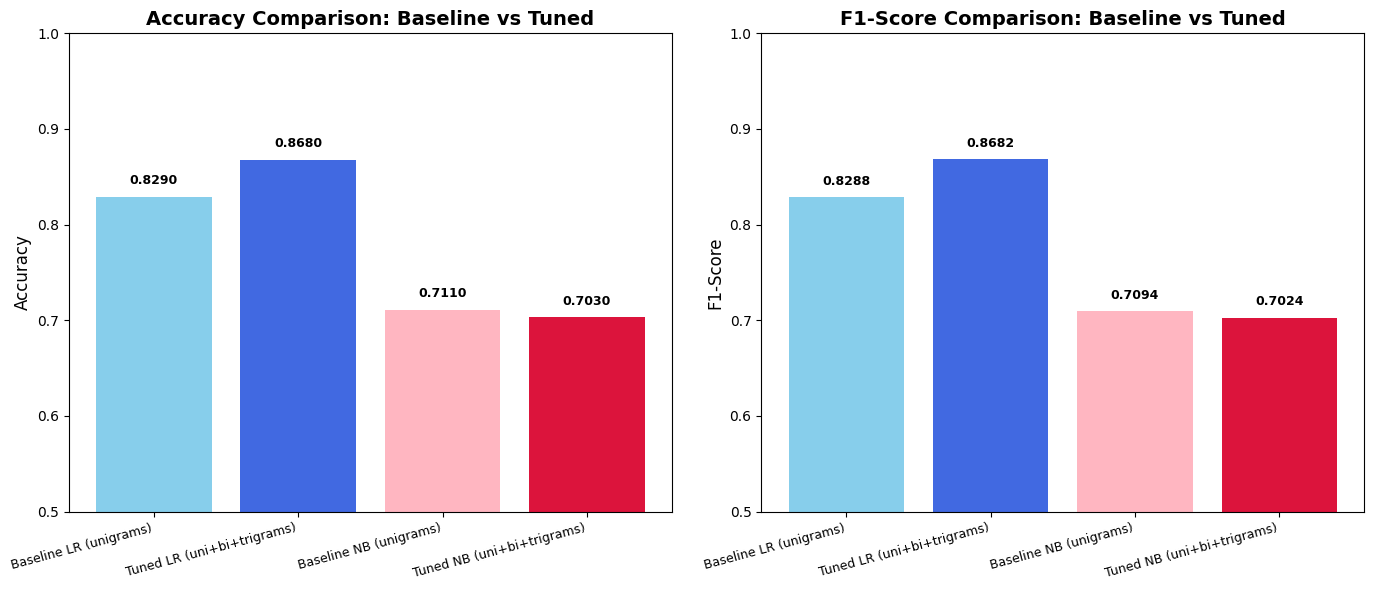

In [65]:
# Compare ALL models: Baseline vs Tuned
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

comparison_data = {
    'Model': [
        'Baseline LR (unigrams)',
        'Tuned LR (uni+bi+trigrams)', 
        'Baseline NB (unigrams)',
        'Tuned NB (uni+bi+trigrams)'
    ],
    'Accuracy': [lr_accuracy, lr_accuracy_tuned, nb_accuracy, nb_accuracy_tuned],
    'F1-Score': [lr_f1, lr_f1_tuned, nb_f1, nb_f1_tuned]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

# Calculate improvements
lr_accuracy_improvement = ((lr_accuracy_tuned - lr_accuracy) / lr_accuracy) * 100
nb_accuracy_improvement = ((nb_accuracy_tuned - nb_accuracy) / nb_accuracy) * 100

print(f"\n{'Improvement Analysis:'}")
print(f"  Logistic Regression: {lr_accuracy_improvement:+.2f}% accuracy improvement")
print(f"  Naive Bayes: {nb_accuracy_improvement:+.2f}% accuracy improvement")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
models = comparison_data['Model']
accuracies = comparison_data['Accuracy']
colors = ['#87CEEB', '#4169E1', '#FFB6C1', '#DC143C']

axes[0].bar(range(len(models)), accuracies, color=colors)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Comparison: Baseline vs Tuned', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(models, rotation=15, ha='right', fontsize=9)
axes[0].set_ylim([0.5, 1.0])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# F1-Score comparison
f1_scores = comparison_data['F1-Score']

axes[1].bar(range(len(models)), f1_scores, color=colors)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('F1-Score Comparison: Baseline vs Tuned', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(models, rotation=15, ha='right', fontsize=9)
axes[1].set_ylim([0.5, 1.0])
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


TUNED LOGISTIC REGRESSION - Classification Report


25/12/11 09:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1913.2 KiB


              precision    recall  f1-score   support

    Negative       0.80      0.91      0.85       172
    Positive       0.91      0.86      0.89       266
  Irrelevant       0.88      0.84      0.86       285
     Neutral       0.87      0.88      0.87       277

    accuracy                           0.87      1000
   macro avg       0.86      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


TUNED LOGISTIC REGRESSION - Confusion Matrix
[[156   5   3   8]
 [ 12 230  14  10]
 [ 15  12 238  20]
 [ 11   6  16 244]]


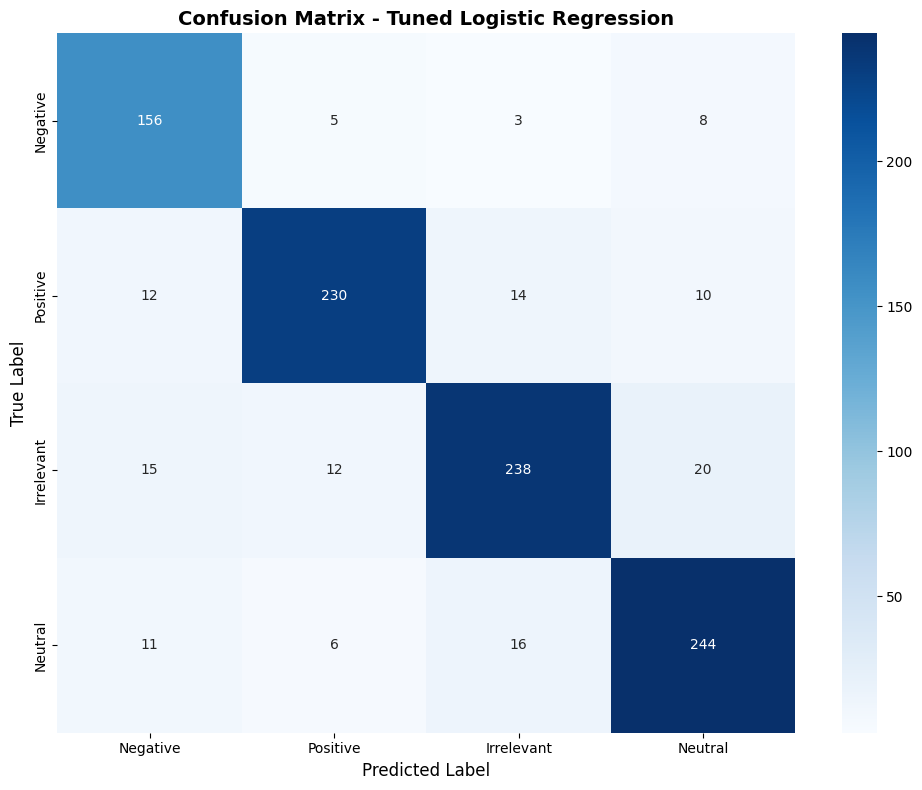

In [66]:
# Detailed classification reports for tuned models
print("\n" + "="*80)
print("TUNED LOGISTIC REGRESSION - Classification Report")
print("="*80)

lr_tuned_pred_pandas = lr_predictions_tuned.select('label', 'prediction').toPandas()
print(classification_report(lr_tuned_pred_pandas['label'], lr_tuned_pred_pandas['prediction'],
                          target_names=['Negative', 'Positive', 'Irrelevant', 'Neutral']))

print("\n" + "="*80)
print("TUNED LOGISTIC REGRESSION - Confusion Matrix")
print("="*80)
lr_cm = confusion_matrix(lr_tuned_pred_pandas['label'], lr_tuned_pred_pandas['prediction'])
print(lr_cm)

# Visualize confusion matrix for best model
plt.figure(figsize=(10, 8))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive', 'Irrelevant', 'Neutral'],
            yticklabels=['Negative', 'Positive', 'Irrelevant', 'Neutral'])
plt.title('Confusion Matrix - Tuned Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


TUNED NAIVE BAYES - Classification Report


25/12/11 09:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1908.4 KiB


              precision    recall  f1-score   support

    Negative       0.64      0.76      0.70       172
    Positive       0.73      0.73      0.73       266
  Irrelevant       0.73      0.62      0.67       285
     Neutral       0.70      0.73      0.71       277

    accuracy                           0.70      1000
   macro avg       0.70      0.71      0.70      1000
weighted avg       0.71      0.70      0.70      1000


TUNED NAIVE BAYES - Confusion Matrix
[[131  14   9  18]
 [ 19 194  27  26]
 [ 32  32 177  44]
 [ 22  25  29 201]]


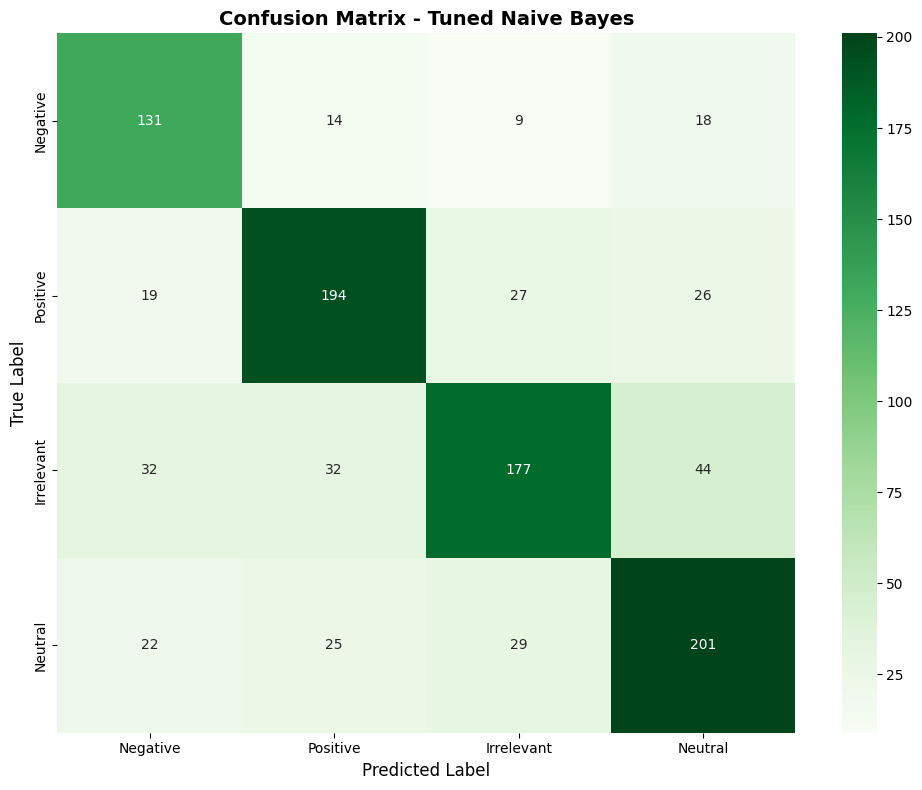

In [67]:
# Tuned Naive Bayes classification report
print("\n" + "="*80)
print("TUNED NAIVE BAYES - Classification Report")
print("="*80)

nb_tuned_pred_pandas = nb_predictions_tuned.select('label', 'prediction').toPandas()
print(classification_report(nb_tuned_pred_pandas['label'], nb_tuned_pred_pandas['prediction'],
                          target_names=['Negative', 'Positive', 'Irrelevant', 'Neutral']))

print("\n" + "="*80)
print("TUNED NAIVE BAYES - Confusion Matrix")
print("="*80)
nb_cm = confusion_matrix(nb_tuned_pred_pandas['label'], nb_tuned_pred_pandas['prediction'])
print(nb_cm)

# Visualize confusion matrix for Naive Bayes
plt.figure(figsize=(10, 8))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive', 'Irrelevant', 'Neutral'],
            yticklabels=['Negative', 'Positive', 'Irrelevant', 'Neutral'])
plt.title('Confusion Matrix - Tuned Naive Bayes', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [68]:
print("="*70)
print("NAIVE BAYES - Classification Report")
print("="*70)
print(classification_report(nb_pred_pandas['label'], nb_pred_pandas['prediction'],
                          target_names=['Negative', 'Positive', 'Irrelevant', 'Neutral']))

print("\n" + "="*70)
print("NAIVE BAYES - Confusion Matrix")
print("="*70)
print(confusion_matrix(nb_pred_pandas['label'], nb_pred_pandas['prediction']))

NAIVE BAYES - Classification Report
              precision    recall  f1-score   support

    Negative       0.64      0.73      0.68       172
    Positive       0.72      0.78      0.75       266
  Irrelevant       0.77      0.59      0.67       285
     Neutral       0.70      0.75      0.72       277

    accuracy                           0.71      1000
   macro avg       0.71      0.71      0.71      1000
weighted avg       0.72      0.71      0.71      1000


NAIVE BAYES - Confusion Matrix
[[126  15   8  23]
 [ 16 208  19  23]
 [ 35  38 169  43]
 [ 19  26  24 208]]


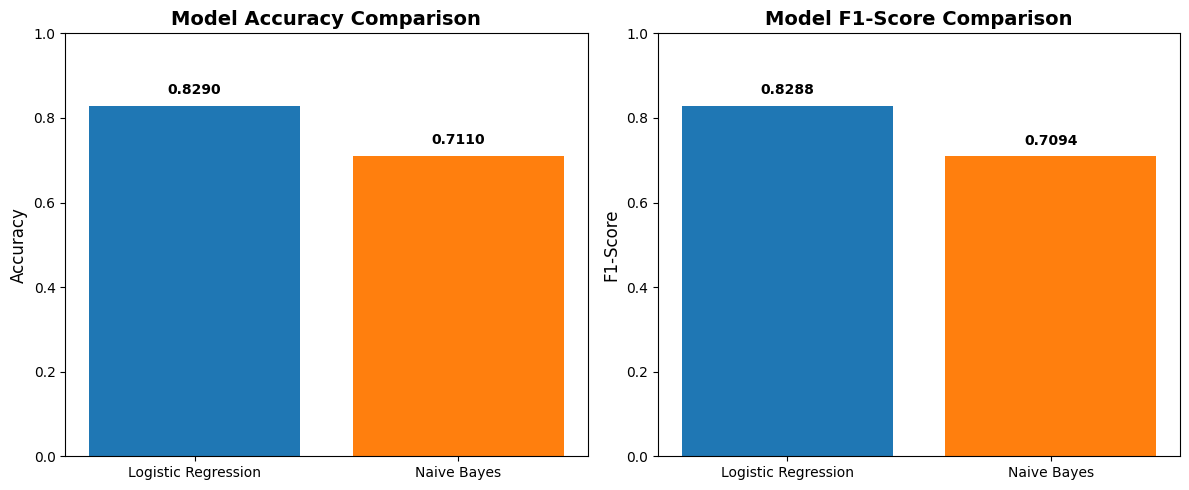


Model                     Accuracy        F1-Score       
-------------------------------------------------------
Logistic Regression       0.8290           0.8288
Naive Bayes               0.7110           0.7094


In [69]:
# Model comparison visualization
models = ['Logistic Regression', 'Naive Bayes']
accuracies = [lr_accuracy, nb_accuracy]
f1_scores = [lr_f1, nb_f1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
axes[0].bar(models, accuracies, color=['#1f77b4', '#ff7f0e'])
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# F1-Score comparison
axes[1].bar(models, f1_scores, color=['#1f77b4', '#ff7f0e'])
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'Model':<25} {'Accuracy':<15} {'F1-Score':<15}")
print("-" * 55)
print(f"{'Logistic Regression':<25} {lr_accuracy:.4f}{'':10} {lr_f1:.4f}")
print(f"{'Naive Bayes':<25} {nb_accuracy:.4f}{'':10} {nb_f1:.4f}")

## 10. Text Mining & Visualization

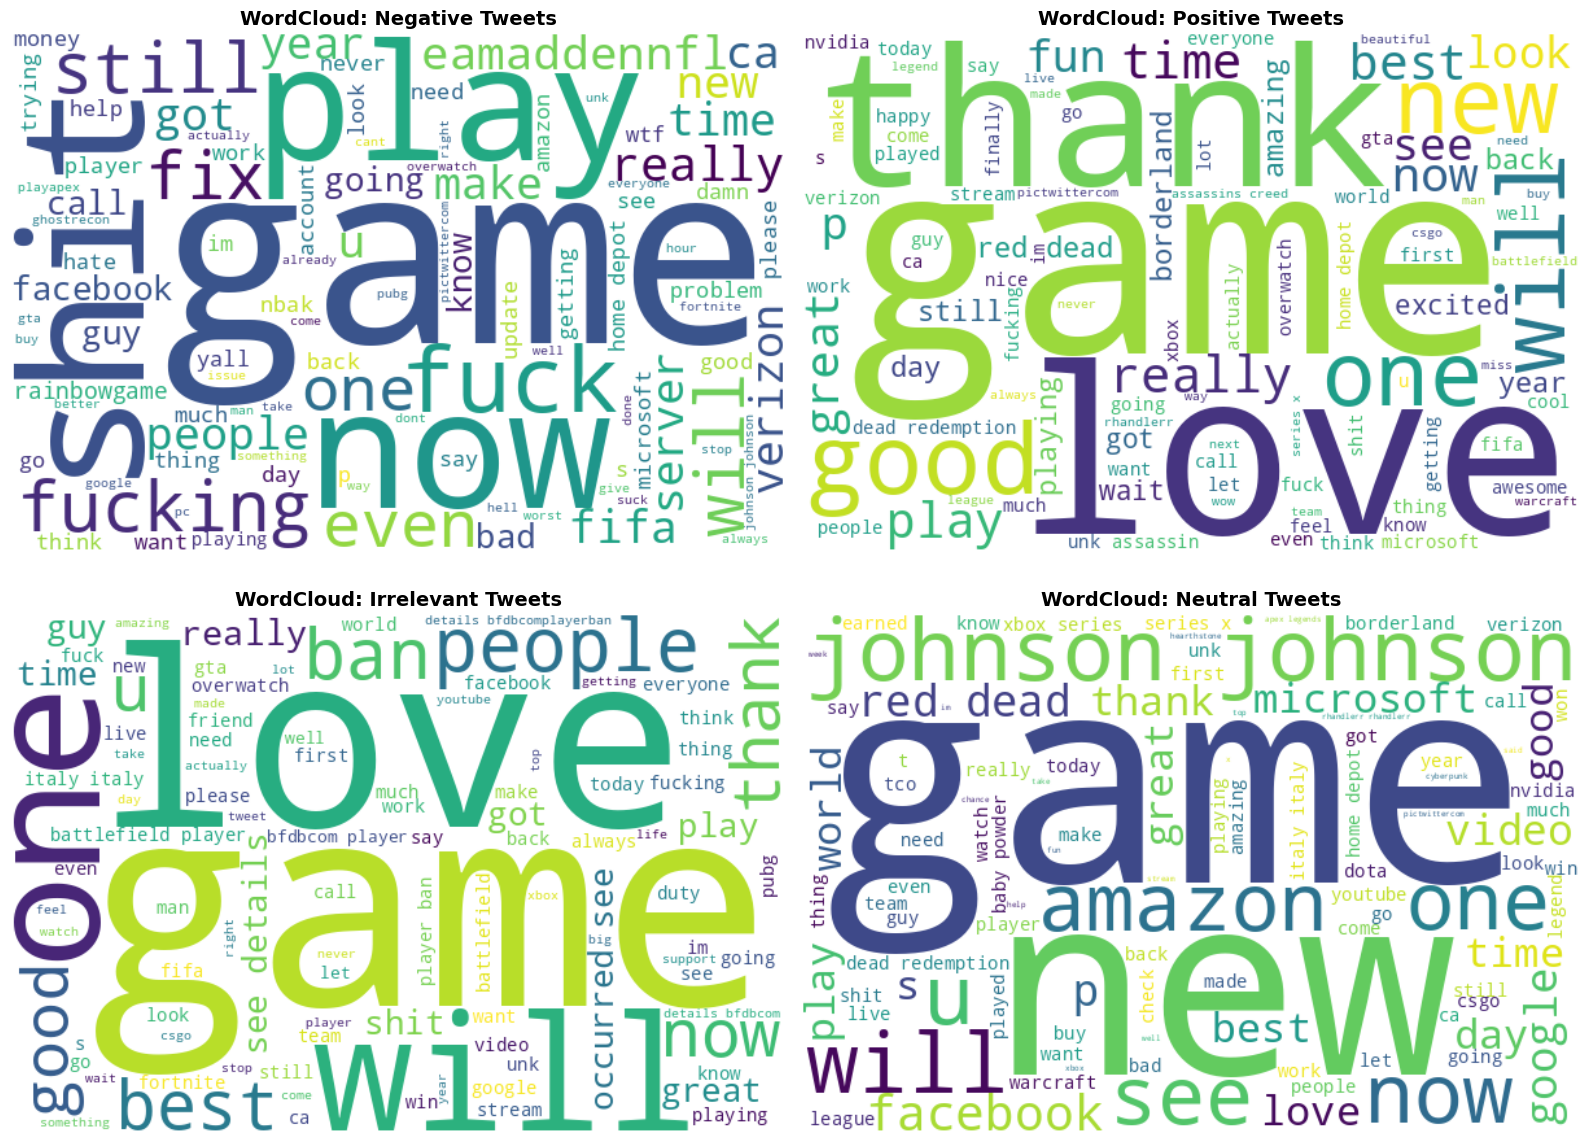

In [70]:
# Generate word clouds for each sentiment
sentiments = ['Negative', 'Positive', 'Irrelevant', 'Neutral']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, sentiment in enumerate(sentiments):
    # Filter text by sentiment
    sentiment_text = spark_train_df.filter(col('sentiment') == sentiment).select('cleaned_text').rdd.map(lambda x: x[0]).collect()
    text_data = ' '.join(sentiment_text)
    
    if text_data.strip():
        # Create word cloud
        wordcloud = WordCloud(width=600, height=400, background_color='white', 
                            colormap='viridis', max_words=100).generate(text_data)
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'WordCloud: {sentiment} Tweets', fontsize=14, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f'No {sentiment} tweets', ha='center', va='center')
        axes[idx].set_title(f'{sentiment} Tweets', fontsize=14, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

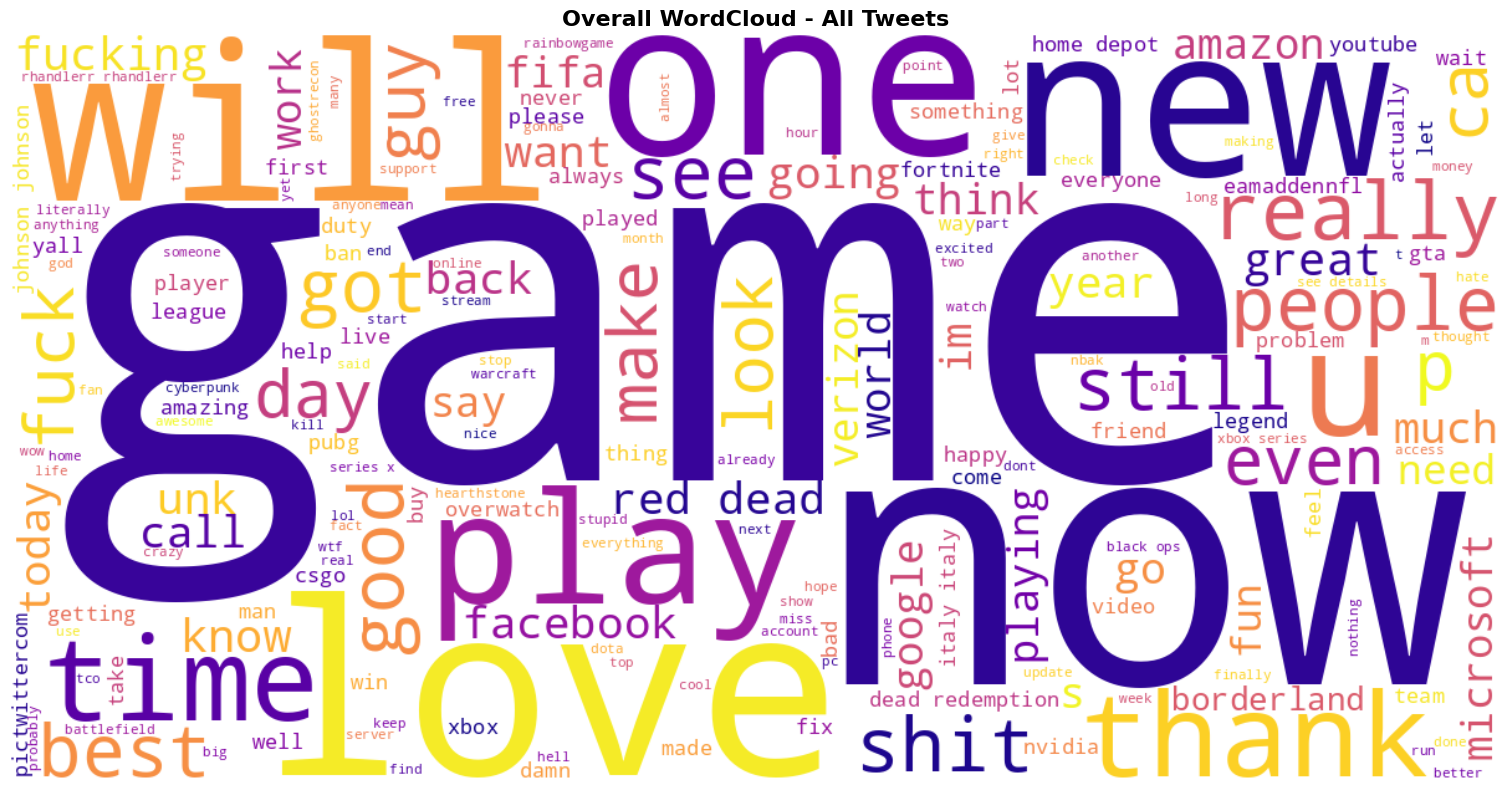

In [71]:
# Overall word cloud
all_text = spark_train_df.select('cleaned_text').rdd.map(lambda x: x[0]).collect()
text_combined = ' '.join(all_text)

plt.figure(figsize=(16, 8))
wordcloud = WordCloud(width=1200, height=600, background_color='white', 
                    colormap='plasma', max_words=200).generate(text_combined)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Overall WordCloud - All Tweets', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## 11. Advanced Analysis: Token Frequency

In [72]:
# Calculate most common tokens by sentiment
from pyspark.sql.functions import explode

# Get top tokens for each sentiment
for sentiment in sentiments:
    print(f"\n{'='*60}")
    print(f"Top 15 Tokens in {sentiment} Tweets")
    print(f"{'='*60}")
    
    token_freq = filtered_train_df.filter(col('sentiment') == sentiment) \
        .select(explode('filtered_tokens').alias('token')) \
        .groupBy('token').count() \
        .orderBy(col('count').desc()) \
        .limit(15) \
        .toPandas()
    
    for idx, row in token_freq.iterrows():
        print(f"{row['token']:<20} : {row['count']:>5}")


Top 15 Tokens in Negative Tweets
game                 :  2103
get                  :   962
like                 :   889
shit                 :   845
fix                  :   732
fuck                 :   717
play                 :   711
eamaddennfl          :   649
still                :   626
fucking              :   626
please               :   619
even                 :   578
really               :   568
one                  :   565
verizon              :   565

Top 15 Tokens in Positive Tweets
game                 :  1384
love                 :  1133
good                 :   995
like                 :   873
really               :   821
new                  :   729
best                 :   694
one                  :   663
time                 :   643
play                 :   642
great                :   614
playing              :   584
fun                  :   566
get                  :   555
games                :   547

Top 15 Tokens in Irrelevant Tweets
like                 :   9

## 12. Save Best Model and Preprocessing Pipeline for Web App

In [73]:
# Save the best model (Tuned Logistic Regression) and preprocessing components
import os

# Create models directory
models_dir = "saved_models"
os.makedirs(models_dir, exist_ok=True)

print("Saving best model and preprocessing pipeline...")

# Save the best Logistic Regression model
lr_best_model.write().overwrite().save(os.path.join(models_dir, "best_lr_model"))

# Save label indexer model
label_model.write().overwrite().save(os.path.join(models_dir, "label_indexer"))

# Save tokenizer
tokenizer.write().overwrite().save(os.path.join(models_dir, "tokenizer"))

# Save stop words remover
remover.write().overwrite().save(os.path.join(models_dir, "stop_words_remover"))

# Save HashingTF models
hashing_tf.write().overwrite().save(os.path.join(models_dir, "hashing_tf"))
hashing_tf_bigram.write().overwrite().save(os.path.join(models_dir, "hashing_tf_bigram"))
hashing_tf_trigram.write().overwrite().save(os.path.join(models_dir, "hashing_tf_trigram"))

# Save IDF model
idf_model.write().overwrite().save(os.path.join(models_dir, "idf_model"))

# Save NGram models
bigram.write().overwrite().save(os.path.join(models_dir, "bigram"))
trigram.write().overwrite().save(os.path.join(models_dir, "trigram"))

# Save vector assembler
assembler.write().overwrite().save(os.path.join(models_dir, "vector_assembler"))

print(f"\n✓ All models saved to '{models_dir}/' directory")
print("\nSaved components:")
print("  - Best Logistic Regression model")
print("  - Label indexer")
print("  - Tokenizer")
print("  - Stop words remover")
print("  - HashingTF (unigrams, bigrams, trigrams)")
print("  - IDF model")
print("  - N-gram models")
print("  - Vector assembler")

Saving best model and preprocessing pipeline...



✓ All models saved to 'saved_models/' directory

Saved components:
  - Best Logistic Regression model
  - Label indexer
  - Tokenizer
  - Stop words remover
  - HashingTF (unigrams, bigrams, trigrams)
  - IDF model
  - N-gram models
  - Vector assembler


In [74]:
# Save statistics and visualizations data for the dashboard
import json
import pickle

# Save sentiment distribution
sentiment_dist_dict = sentiment_dist.to_dict(orient='records')

# Save game distribution
game_dist_dict = game_dist.to_dict(orient='records')

# Save top tokens by sentiment
top_tokens_by_sentiment = {}
for sentiment_name in sentiments:
    token_freq = filtered_train_df.filter(col('sentiment') == sentiment_name) \
        .select(explode('filtered_tokens').alias('token')) \
        .groupBy('token').count() \
        .orderBy(col('count').desc()) \
        .limit(15) \
        .toPandas()
    top_tokens_by_sentiment[sentiment_name] = token_freq.to_dict(orient='records')

# Save model performance metrics
model_metrics = {
    'baseline_lr': {'accuracy': lr_accuracy, 'f1_score': lr_f1},
    'tuned_lr': {'accuracy': lr_accuracy_tuned, 'f1_score': lr_f1_tuned},
    'baseline_nb': {'accuracy': nb_accuracy, 'f1_score': nb_f1},
    'tuned_nb': {'accuracy': nb_accuracy_tuned, 'f1_score': nb_f1_tuned}
}

# Save confusion matrix for best model
confusion_matrix_data = lr_cm.tolist()

# Create data package
dashboard_data = {
    'sentiment_distribution': sentiment_dist_dict,
    'game_distribution': game_dist_dict,
    'top_tokens_by_sentiment': top_tokens_by_sentiment,
    'model_metrics': model_metrics,
    'confusion_matrix': confusion_matrix_data,
    'sentiment_labels': sentiments
}

# Save to JSON
with open(os.path.join(models_dir, 'dashboard_data.json'), 'w') as f:
    json.dump(dashboard_data, f, indent=2)

print("✓ Dashboard data saved to 'dashboard_data.json'")
print(f"\nData includes:")
print(f"  - Sentiment distribution ({len(sentiment_dist_dict)} categories)")
print(f"  - Game distribution ({len(game_dist_dict)} games)")
print(f"  - Top 15 tokens for each sentiment class")
print(f"  - Model performance metrics")
print(f"  - Confusion matrix for best model")

✓ Dashboard data saved to 'dashboard_data.json'

Data includes:
  - Sentiment distribution (4 categories)
  - Game distribution (32 games)
  - Top 15 tokens for each sentiment class
  - Model performance metrics
  - Confusion matrix for best model
